### Theoretical methods of deep learning: Homework assignment 3
Submit solution by uploading to canvas, **by Sunday, November 27th, 23:59**

**Task 1.** Consider the hierarchical broadcasting with the 3-state spin and the cyclic transition matrix 

$$P=\begin{pmatrix}
1-\epsilon & \epsilon & 0 \\
0 & 1-\epsilon & \epsilon \\
\epsilon & 0 & 1-\epsilon\end{pmatrix}.$$

1. Implement a simulation of broadcasing and the maximum likelihood reconstruction algorithm for this model.
2. Study numerically the performance of the ML reconstruction algorithm for flows with several small branching numbers $b$ and error rates varying between 0 and 1. Do you observe a phase transition between solvable and non-solvable reconstruction phases? (Recall that in the non-solvable phase the probability of correct reconstruction by ML converges in the large depth limit to the probability of correct reconstruction by random guessing, while in the solvable phase these probabilities remain separated by some depth-independent gap.) If yes, what are the approximate critical values of $\epsilon$ for different branching numbers? Compare the obtained experimental results with the theoretical results on reconstruction solvability.

**Task 2.** Consider the hierarchical flow with the standard binary symmetric channel. Let us say that the reconstruction of the root spin by a particular algorithm applied to a final configuration  $\sigma_n$ is *correct* if it agrees with  the optimal (ML) reconstruction. Suppose that the branching number is odd so that the local majority algorithm is well-defined. 
1. Prove that for any final spin configuration $\sigma_n$ the **local** majority reconstruction is correct if the error rate $\epsilon$ is small enough (i.e., the ML algorithm converges to the local majority algorithm as $\epsilon\to 0$). 
2. Give an example of a final spin configuration $\sigma_n$ for which the **global** majority reconstruction is wrong for all sufficiently small error rates $\epsilon$.

# Task 1

Possible states: 0, 1, 2. With probability $\epsilon$ state changes to $(\text{state} + 1) \% 3$, otherwise it stays the same.

In [1]:
from __future__ import print_function 
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

In [2]:
def makeRandFlips(spinA,  # input spins at a certain hierarchy level, as an array 
                  b,      # branching number
                  eps     # spin flip probability
                  ):
    shape1 = [b] + list(spinA.shape)
    spinA1 = np.empty(shape1, 'int')
    for a in range(b):
        flipA = np.random.rand(*list(spinA.shape)) < eps
        spinA1[a] = flipA * ((spinA + 1) % 3) + (1 - flipA) * spinA
        
    return spinA1    # spins at the next level



def runRandFlow(depth, 
                b,
                eps,
                root=0
               ): # run a full random hierarchical flow of spin flips
    spinA = np.array([root], 'int')
    spinAL = [spinA]

    for level in range(depth):
        spinAL.append(makeRandFlips(spinAL[-1], b, eps))
    return spinAL # the full flow as a list of arrays


colors = {0:'r', 1:'g', 2:'b'}
def spinAL2tree(spinAL,
                plot=True,
                savefig=False
               ): # convert spin array list into a tree
    tree = nx.DiGraph()
    for level in range(len(spinAL)):
        for index, value in np.ndenumerate(spinAL[level]):
            node = tree.add_node(index)
            tree.nodes[index]['v'] = value
            if level > 0:
                predecessor = tuple(list(index)[1:])
                tree.add_edge(predecessor, index)
    
    # assign reasonable positions and colors for visualization
    pos = nx.spring_layout(tree)
    for level in range(len(spinAL)):  
        for index, value in np.ndenumerate(spinAL[level]):
            pos[index] = (np.sum([3.1**(l-level)*(index[l]-(spinAL[level].shape[l]-1.)/2)/(spinAL[level].shape[l]-1.+1e-8) 
                                  for l in range(level+1)]),
                         -level)  
    if plot:
        nx.draw(tree, pos, node_color=[colors[tree.nodes[node]['v']] for node in tree.nodes], node_size=100)
        if savefig:
            plt.savefig('tree.pdf')
    return tree

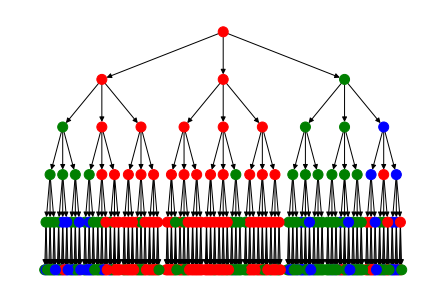

In [3]:
spinAL = runRandFlow(depth=5, 
                     b=3,
                     eps=0.2,
                     root=0)

tree = spinAL2tree(spinAL)

In [4]:
def reconstruct(spinA, # final layer 
                method='maxLikelihood',
                eps=0.5 # needed for Max Likelihood reconstruction
               ):
    if method == 'random':
        return np.random.randint(0, 3)
    elif method == 'maxLikelihood':
        spinA_0 = (spinA == 0)
        spinA_1 = (spinA == 1)
        spinA_2 = (spinA == 2)

        for layer in range(len(spinA.shape)-1):
            spinA_0, spinA_1, spinA_2 = ((spinA_0 * (1 - eps) + spinA_1 * eps).prod(axis=0), 
                                         (spinA_1 * (1 - eps) + spinA_2 * eps).prod(axis=0),
                                         (spinA_2 * (1 - eps) + spinA_0 * eps).prod(axis=0))


                # normalize to avoid convergence to 0
            m = spinA_0 + spinA_1 + spinA_2
            spinA_0, spinA_1, spinA_2 = spinA_0 / m, spinA_1 / m, spinA_2 / m


        max_prob = max(spinA_0, spinA_1, spinA_2)
        if max_prob == spinA_0:
            return 0
        elif max_prob == spinA_1:
            return 1
        else:
            return 2

True root: 2


NameError: name 'ml_reconstruct' is not defined

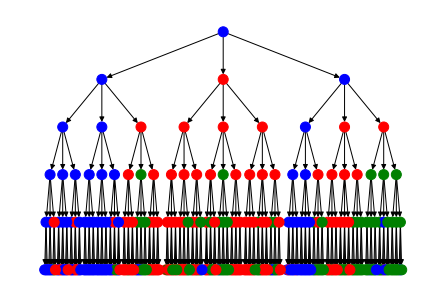

In [5]:
def testReconstruct():
    root = 2
    print ('True root:', root)
    
    depth = 5
    b = 3
    eps = 0.2

    spinAL = runRandFlow(depth=depth, 
                 b=b,
                 eps=eps,
                 root=root)

    tree = spinAL2tree(spinAL)

    root = reconstruct(spinAL[-1], eps)
    print (root)
        
testReconstruct()

In [7]:
methodL = ['random', 'maxLikelihood']


def getShareCorrect(Nruns,
                   depth,
                   b,
                   eps,
                   methodL
                  ):
    Ncorrect = {}
    for method in methodL:
        Ncorrect[method] = 0 

    for _ in range(Nruns):
        root = np.random.randint(0,3)
        spinAL = runRandFlow(depth=depth, 
                             b=b,
                             eps=eps,
                             root=root)
        for method in methodL:
            rootPred = reconstruct(spinAL[-1], method, eps)
            Ncorrect[method] += rootPred == root
    
    shareCorrect = dict([(method, float(Ncorrect[method])/Nruns) for method in methodL])
    return shareCorrect    

$$\lambda_2 = 1 - x\frac{3 \pm i\sqrt{3}}{2}$$
<br>
$$|\lambda_2|^2 = \left(1 - \frac{3x}{2} \right)^2 + \frac{3x^2}{4}$$
$$|\lambda_2|^2 = 1/b \Rightarrow x = 3 - \frac{\sqrt{3(4 - b) / b}}{6}$$

Stigum-Kesten critical epsilon: 0.21132486540518713


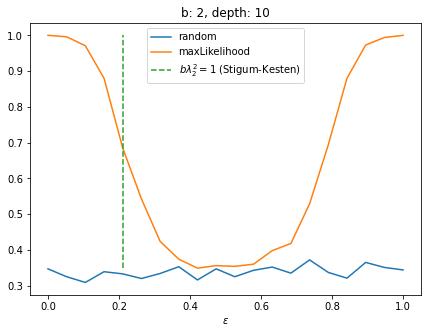

Stigum-Kesten critical epsilon: 0.21132486540518713


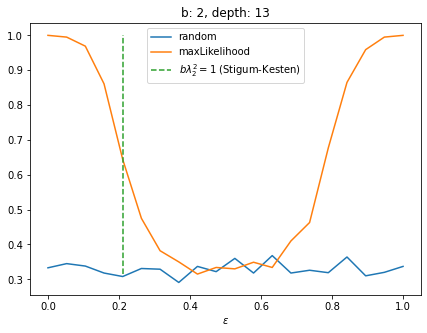

Stigum-Kesten critical epsilon: 0.21132486540518713


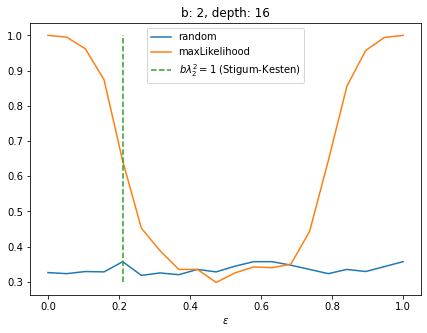

In [10]:
Nruns = 1000
for depth in range(10, 17, 3):
    b = 2
    epsL = np.linspace(0, 1, 20)
    shareCorrect = {}
    for method in methodL:
        shareCorrect[method] = []
    for eps in epsL:
        res = getShareCorrect(Nruns, depth, b, eps, methodL)
        for method in methodL:
            shareCorrect[method].append(res[method])

    plt.figure(figsize=(7,5))

    for method in methodL:
        plt.plot(epsL, shareCorrect[method], label=method)

    yrange = [np.min(shareCorrect['maxLikelihood']), np.max(shareCorrect['maxLikelihood'])]

    eps_crit_SK = (3 - np.sqrt(3 * (4 - b) / b)) / 6
    print ('Stigum-Kesten critical epsilon:', eps_crit_SK)
    plt.plot([eps_crit_SK, eps_crit_SK], yrange, '--', label='$b\lambda_2^2=1$ (Stigum-Kesten)')


    plt.legend()
    plt.xlabel('Success probability')
    plt.xlabel('$\epsilon$')
    plt.title('b: %d, depth: %d' %(b, depth))
    plt.savefig('reconstruction_comparison.pdf')
    plt.show()

As we can see from these plots, theoretical value for $\epsilon_\text{critical}$ coincise with expirementally obtained results.

# Task 2

Consider 1 node $(\sigma_0)$ with $b$ descendants ($\sigma_1$). Let there be $k$ "+" states and $b - k$ "-" states.
$$P(\sigma_1|\sigma_0=+) = \epsilon^{b - k} (1 - \epsilon)^{k}$$
$$P(\sigma_1|\sigma_0=-) = \epsilon^{k} (1 - \epsilon)^{b - k}$$
If $b > 2k$ and $1 - \epsilon > \epsilon \Rightarrow \epsilon < 0.5$:
$$ \epsilon^{b - 2k} < (1 - \epsilon)^{b - 2k} \quad \big| \cdot \epsilon^k (1 - \epsilon)^{k}$$
$$ (1 - \epsilon)^k \epsilon^{b - k} < (1 - \epsilon)^{b - k} \epsilon^{k}$$
$$P(\sigma_1|\sigma_0=+) <  P(\sigma_1|\sigma_0=-)$$
So both local majority and ml predict "-". <br>
Same for $b < 2k$ and $\epsilon < 0.5$:
$$ \epsilon^{b - 2k} > (1 - \epsilon)^{b - 2k} \quad \big| \cdot \epsilon^k (1 - \epsilon)^{k}$$
$$ (1 - \epsilon)^k \epsilon^{b - k} > (1 - \epsilon)^{b - k} \epsilon^{k}$$
$$P(\sigma_1|\sigma_0=+) > P(\sigma_1|\sigma_0=-)$$
both local majority and ml predict "+". <br>
Now if we consider arbitrary depth, we can do the same steps starting from the bottom layer and arrive at the same result.

Consider $b = 5$, $\text{depth} = 3$. Take the following final layer:
$$(- - + + +) \quad (- - + + +) \quad (- - + + +) \quad (- - - - -) \quad (- - - - -)$$
Global majority will predict $\sigma^\text{global}_0 = -$, but local majority will predict $\sigma^\text{local}_0 = +$. Since the ML algorithm converges to the local majority algorithm as $\epsilon \to 0$ it should also predict $\sigma^\text{ML}_0 = +$.